In [1]:
import numpy as np
import pandas as pd

import glob, random, os, warnings
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from time import time
import time as t
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#To get the same results in different environments
def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "True"
    os.environ["TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS"] = "True"

seed_everything()
warnings.filterwarnings('ignore')



print('TensorFlow Version ' + tf.__version__)

2023-12-05 11:17:01.938428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 11:17:02.508639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow Version 2.13.1


In [3]:
image_size = 224
batch_size = 12
n_classes = 2
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 200
dataset_path = './data'
dataset_raw_path='dataset_raw\\'

mlp_rate = 2
patch_size = 16  # Size of the patches to be used while extracting them from images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8

In [4]:
# import splitfolders


# splitfolders.ratio(dataset_raw_path, # The location of dataset
#                     output=dataset_path, # The output location
#                     seed=42, # The number of seed
#                     ratio=(.7, .2, .1), # The ratio of splited dataset
#                     group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                     move=False # If you choose to move, turn this into True
#                     )

In [5]:
dataset_classes = ['missing', 'present']
class_to_label_map = {}
for (index, class_name) in enumerate(dataset_classes):
  class_to_label_map[index] = class_name

print(class_to_label_map)

{0: 'missing', 1: 'present'}


In [6]:
def add_all_image_as_dataframe(dataset_type):
    df = pd.DataFrame(columns =['class', 'directory'])
    for class_name in dataset_classes:
      class_path = dataset_path+'/'+dataset_type+'/'+class_name
      print(f'Collecting data from "{class_path}"')
      for path, names, filenames in os.walk(class_path):
          for filename in filenames:
              df.loc[-1] = [class_name, (class_path + filename)]
              df.index = df.index + 1
              df = df.sort_index()
    return df



In [7]:
# Train Dataset from the folder
df_train = add_all_image_as_dataframe('train')
X_train = df_train['directory']
Y_train = df_train['class']

# Test Dataset from the folder
df_test = add_all_image_as_dataframe('test')
X_test = df_test['directory']
Y_test = df_test['class']

# Validation Dataset from the folder
df_valid = add_all_image_as_dataframe('val')
X_valid = df_valid['directory']
Y_valid = df_valid['class']

In [8]:
print(f"""
{'-'*40}
# Train samples: {Y_train.shape}
# Test samples: {Y_test.shape}
# Valid samples: {Y_valid.shape}
{'-'*40}
""")


----------------------------------------
# Train samples: (101,)
# Test samples: (16,)
# Valid samples: (28,)
----------------------------------------



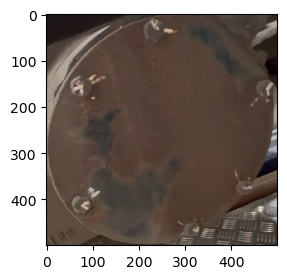

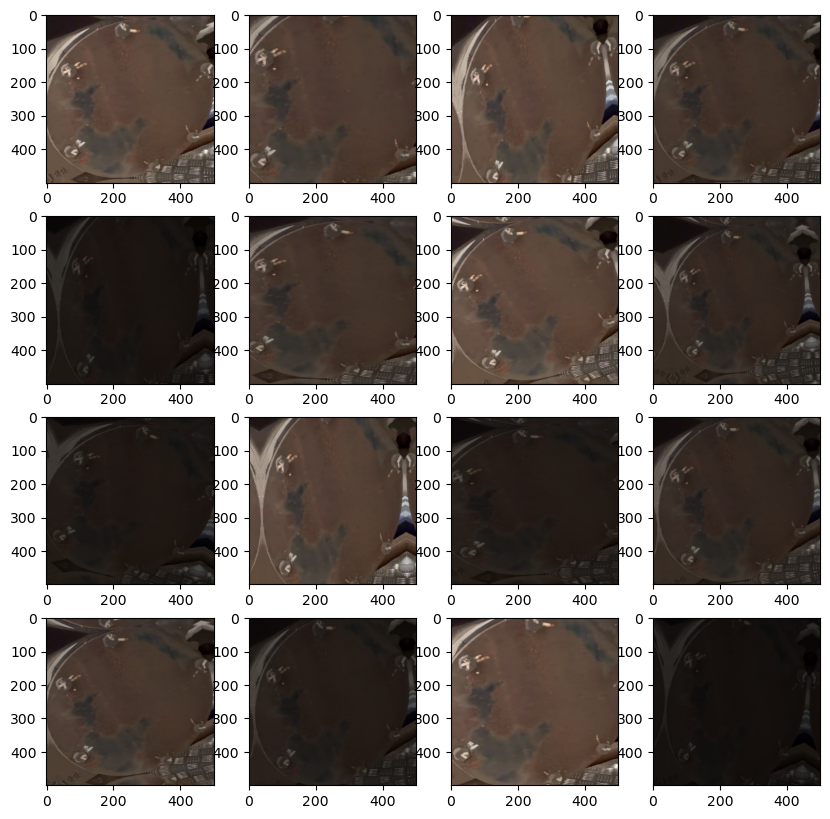

In [9]:
# Data augmentation methods are applied here!
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center="True",
                                                          featurewise_std_normalization="True",
                                                          shear_range=0.25,
                                                          zoom_range=0.2,
                                                          rotation_range=15,
                                                          brightness_range=[
                                                              0.15, 1.15],
                                                          width_shift_range=[
                                                              -2, -1, 0, +1, +2],
                                                          height_shift_range=[
                                                              -1, 0, +1],
                                                          fill_mode='reflect')

#Creates our batch of one image
# image_path = 'dataset\\train\\damage\\output_0019_jpg.rf.4f7056dc09367d43b552e7236a953714.jpg'
image_path = 'data/test/present/frame_1671.jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size= (500,500))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Allows us to properly visualize our image by rescaling values in array
img_tensor /= 255.
plt.figure(figsize=(3,3))
plt.imshow(img_tensor[0])
plt.show()
pic = datagen.flow(img_tensor*255, batch_size =1)
plt.figure(figsize=(10, 10))
#Plots our figures
for i in range(1,17):
    plt.subplot(4, 4, i)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    plt.imshow(image_)
plt.show()


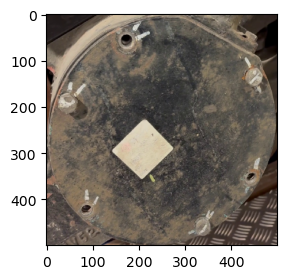

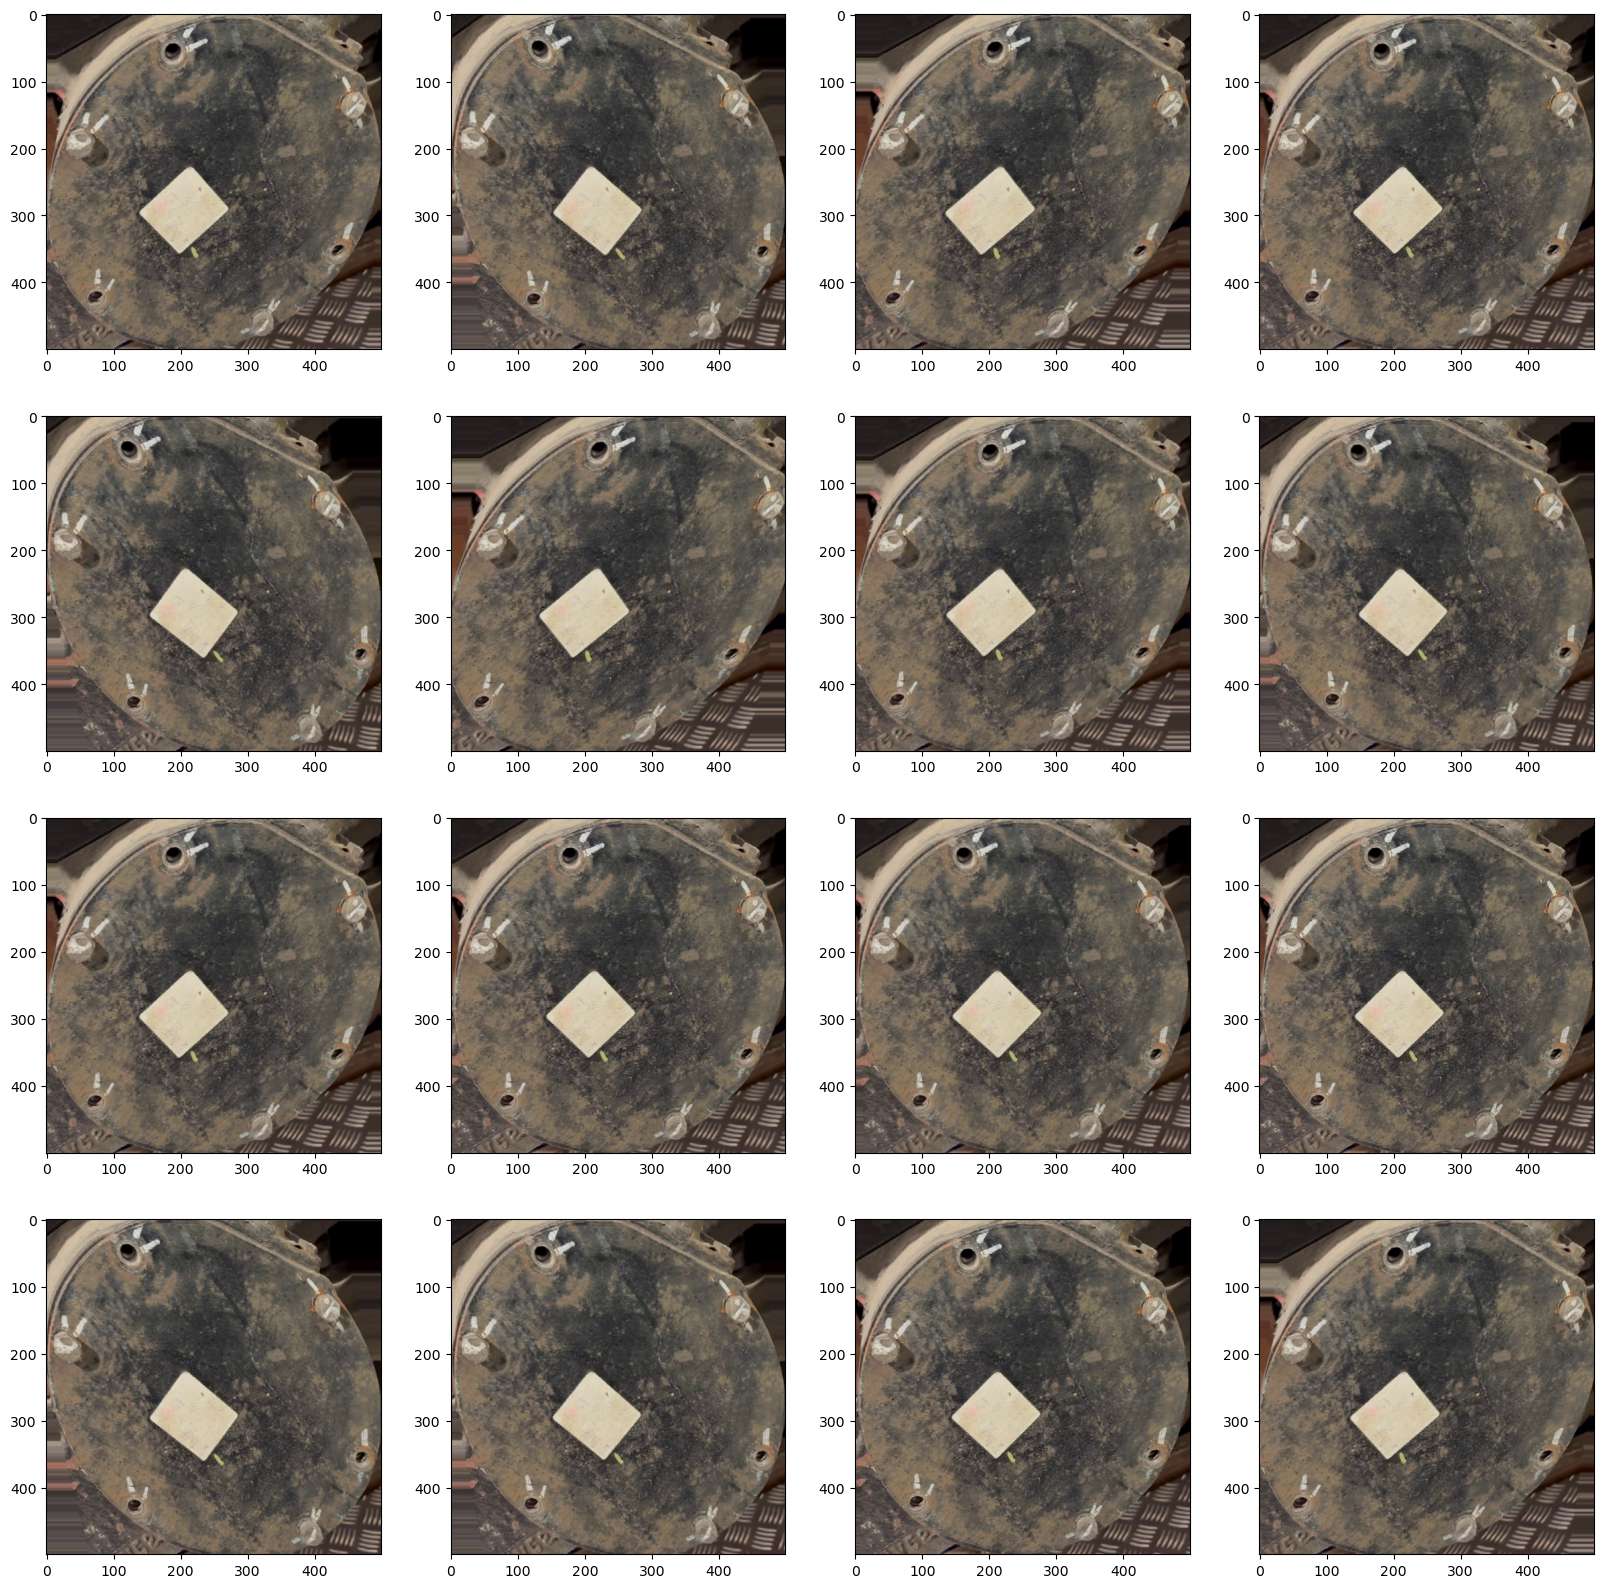

In [10]:
# Data augmentation methods are applied here!
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=15)

#Creates our batch of one image
# image_path = 'dataset\\train\\damage\\output_0019_jpg.rf.4f7056dc09367d43b552e7236a953714.jpg'
image_path = 'data/test/missing/frame_542.jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size= (500,500))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Allows us to properly visualize our image by rescaling values in array
img_tensor /= 255.
plt.figure(figsize=(3,3))
plt.imshow(img_tensor[0])
plt.show()
pic = test_datagen.flow(img_tensor*255, batch_size =1)
plt.figure(figsize=(20, 20))
#Plots our figures
for i in range(1,17):
    plt.subplot(4, 4, i)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    plt.imshow(image_)
plt.show()


In [11]:
train_path = dataset_path + '/train'
test_path = dataset_path + '/test'
valid_path = dataset_path + '/val'
# Data augmentation methods are applied here!
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          featurewise_center="True",
                                                          featurewise_std_normalization="True",
                                                          shear_range=0.25,
                                                          zoom_range=0.2,
                                                          rotation_range=15,
                                                          brightness_range=[
                                                              0.15, 1.15],
                                                          width_shift_range=[
                                                              -2, -1, 0, +1, +2],
                                                          height_shift_range=[
                                                              -1, 0, +1],
                                                          fill_mode='reflect')

# Different generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(directory=train_path,
                                        batch_size=batch_size,
                                        seed=1,
                                        color_mode='grayscale',
                                        shuffle=True,
                                        class_mode='categorical',
                                        target_size=(image_size, image_size))

valid_gen = datagen.flow_from_directory(directory=valid_path,
                                        batch_size=batch_size,
                                        seed=1,
                                        color_mode='grayscale',
                                        shuffle=True,
                                        class_mode='categorical',
                                        target_size=(image_size, image_size))


test_gen = test_datagen.flow_from_directory(
    directory=test_path,
    color_mode="grayscale",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=1,
    target_size=(image_size, image_size)
)


Found 101 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Custom VIT

## Patch + Position Embedding

This block is responsible for creating patches from the input image and adds a positional token as in NLP practices.

In [11]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self , size , num_of_patches , projection_dim):
        super().__init__()

        self.size=size
        self.num_of_patches= num_of_patches + 1
        self.projection_dim=projection_dim

        self.projection=tf.keras.layers.Dense(projection_dim)

        self.clsToken= tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)
        #create vector for each patch 
        self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)


    def call(self, inputs):
        patches = tf.image.extract_patches(inputs , sizes=[1 , self.size , self.size , 1], strides=[1 , self.size , self.size , 1], rates=[1 ,1 ,1 ,1], padding="VALID",)
        patches=tf.reshape(patches, (tf.shape(inputs)[0], -1, self.size * self.size *1))
        patches= self.projection(patches)

        # repeat cls token length of batch size
        clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)
        patches = tf.concat((clsToken, patches) , axis=1)
        # create position number for each patch
        positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
        positionalEmbedding = self.positionalEmbedding(positions)

        #print(positionalEmbedding)
        patches= patches + positionalEmbedding
        return patches

Let's plot the patches for a simpler case (In the model training, there are way more patches!)

2023-12-05 00:38:24.019200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 00:38:24.060943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 00:38:24.061197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Image size: 224 X 224
Patch size: 128 X 128
Patches per image: 16
Elements per patch: 49152


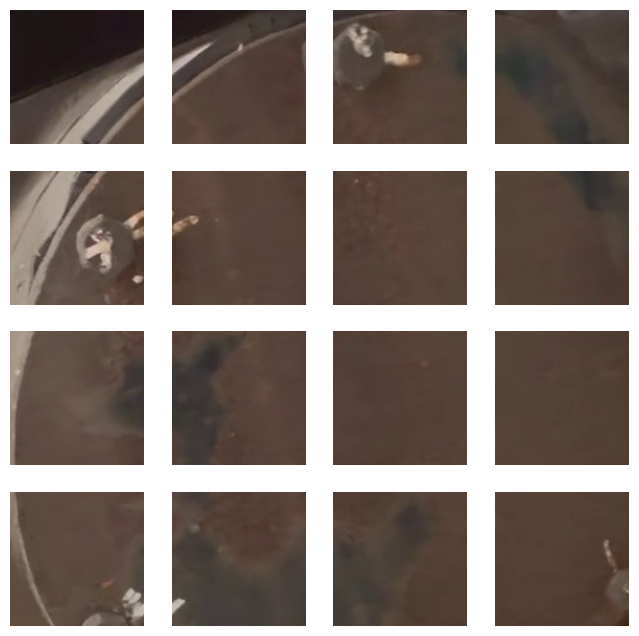

In [12]:
def patch_plot(input_path):

    patch_size = 128
    image_path = input_path
    image = tf.keras.preprocessing.image.load_img(image_path)
    imageArray=tf.keras.preprocessing.image.img_to_array(image)
    imageArray = imageArray[tf.newaxis , ...]
    patches= tf.image.extract_patches(imageArray, sizes=[1 , patch_size , patch_size ,1], strides=[1 , patch_size ,patch_size , 1] , rates=[1,1,1,1], padding="VALID" )
    patches=tf.reshape(patches , shape=(tf.shape(patches)[0] , -1 , patch_size*patch_size*3))

    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(8, 8))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")
    #plt.savefig('patches.png', dpi=1200)
# patch_plot('dataset\\train\\damage\\output_0019_jpg.rf.4f7056dc09367d43b552e7236a953714.jpg')
patch_plot('data/test/present/frame_1671.jpg')

Flattened version of the patches

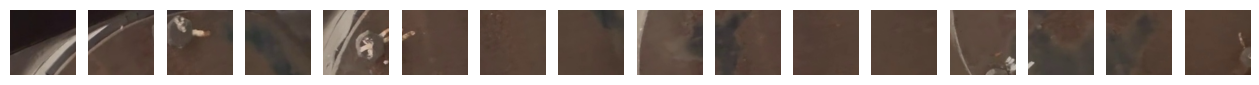

In [13]:
patch_size_2 = 128
image_path = 'data/test/present/frame_1671.jpg'
image = tf.keras.preprocessing.image.load_img(image_path)
imageArray=tf.keras.preprocessing.image.img_to_array(image)
imageArray = imageArray[tf.newaxis , ...]
patches= tf.image.extract_patches(imageArray, sizes=[1 , patch_size_2 , patch_size_2 ,1], strides=[1 , patch_size_2 ,patch_size_2 , 1] , rates=[1,1,1,1], padding="VALID" )
patches=tf.reshape(patches , shape=(tf.shape(patches)[0] , -1 , patch_size_2*patch_size_2*3))


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(n *n , 1))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(1 ,n*n , i + 1)
    patch_img = tf.reshape(patch, (128, 128, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
#plt.savefig('patches_flat.png', dpi=600)

## Transformer Encoder

In [14]:
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
        super().__init__()

        self.layernorm_1 = LayerNormalization(epsilon=1e-6)
        self.mha= tf.keras.layers.MultiHeadAttention(heads, d_model//heads , dropout=dropout_rate)

        self.layernorm_2 = LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
                                        Dense(d_model * mlp_rate , activation="gelu"),
                                        Dropout(dropout_rate),
                                        Dense(d_model , activation="gelu"),
                                        Dropout(dropout_rate)
        ])
    def call(self , inputs , training=True):
        out_1 = self.layernorm_1(inputs)
        out_1 = self.mha(out_1 , out_1 ,training=training)
        out_1 = inputs + out_1

        out_2= self.layernorm_2(out_1)
        out_2=self.mlp(out_2 , training=training)
        out_2 = out_1 + out_2

        return out_2

In [15]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
        super().__init__()

        self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]

    def call(self , inputs , training=True):
        x =inputs

        for layer in self.encoders:
            x = layer(x , training=training)

        return x

## Let's combine the building blocks and create the model!

In [16]:
class VisionTransformer(tf.keras.Model):
    def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1):
        super().__init__()

        self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
        self.encoder = TransformerEncoder(d_model , heads , mlp_rate  ,num_layers , dropout_rate)

        self.prediction = tf.keras.Sequential([
                                               tf.keras.layers.Dropout(0.3),
                                               tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                               tf.keras.layers.Dropout(0.2),       
                                               tf.keras.layers.Dense(num_classes, activation="softmax")


      ])
    def call(self , inputs ,  training=True):
        patches = self.patchEmbedding(inputs)
        encoderResult = self.encoder(patches, training=training)

        clsResult = encoderResult[: , 0 , :]

        prediction = self.prediction(clsResult,
                                     training=training)
        return prediction

## **Training the Model**

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = VisionTransformer(n_classes,
                          patch_size,
                          num_patches,
                          projection_dim,
                          num_heads,
                          transformer_layers,
                          mlp_rate,
                          dropout_rate=0.1)
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                         tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                        ],
             )


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 0,
                                                 patience = 15,
                                                 mode = 'auto',
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model_ViT.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

callbacks = [earlystopping, lr_scheduler, checkpointer]

startTrain_ViT = time()
history = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)
time_passed_ViT = time()-startTrain_ViT

2023-12-05 00:38:31.514602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200


2023-12-05 00:38:40.392283: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560e37fd6610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 00:38:40.392315: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-12-05 00:38:40.397290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 00:38:40.572612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-12-05 00:38:40.679577: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 [==============================] - ETA: 0s - loss: 1.0459 - accuracy: 0.4944 - top-5-accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./model_ViT.hdf5
8/8 [==============================] - 19s 380ms/step - loss: 1.0459 - accuracy: 0.4944 - top-5-accuracy: 1.0000 - val_loss: 0.7011 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 1.1221 - accuracy: 0.4494 - top-5-accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.50000 to 0.62500, saving model to ./model_ViT.hdf5
8/8 [==============================] - 2s 267ms/step - loss: 1.1221 - accuracy: 0.4494 - top-5-accuracy: 1.0000 - val_loss: 0.8033 - val_accuracy: 0.6250 - val_top-5-accuracy: 1.0000 - lr: 9.6194e-04
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.7891 - accuracy: 0.6067 - top-5-accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.62500
8/8 [==============================

In [18]:
model.save("ViT_model")
# !zip -r file.zip /ViT_model
np.save('history_ViT.npy',history.history)

INFO:tensorflow:Assets written to: ViT_model/assets


INFO:tensorflow:Assets written to: ViT_model/assets


In [19]:
#loading
#history=np.load('history_ViT.npy',allow_pickle='TRUE').item()

In [20]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding (PatchEmbe  multiple                  29120     
 dding)                                                          
                                                                 
 transformer_encoder (Trans  multiple                  267776    
 formerEncoder)                                                  
                                                                 
 sequential_8 (Sequential)   (None, 2)                 8578      
                                                                 
Total params: 305474 (1.17 MB)
Trainable params: 305474 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Running time & memory occupation(complexity) of the model

In [21]:
print("Trainable parameters: ",model.count_params() )

print("Running time: ",t.strftime("%Hh%Mm%Ss", t.gmtime(time_passed_ViT)))

Trainable parameters:  305474
Running time:  00h00m59s


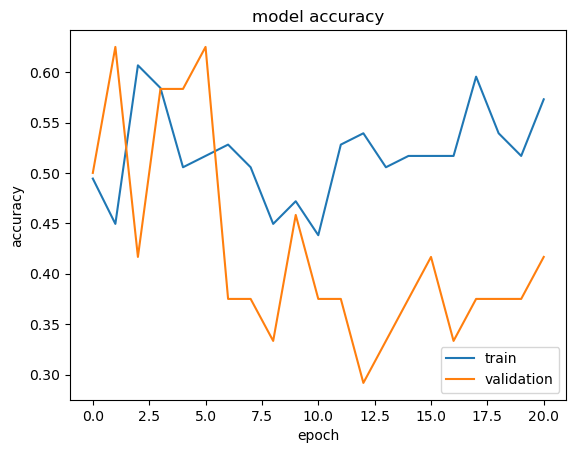

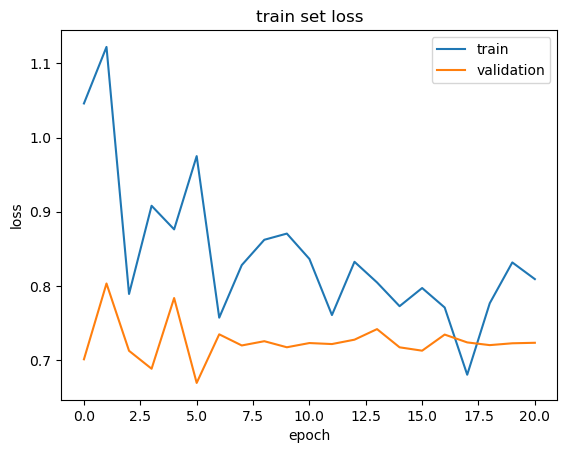

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Let's PREDICT!!

In [23]:
test_gen.reset()
predY=model.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

16/16 [==============================] - 1s 8ms/step


## Confusion Matrix

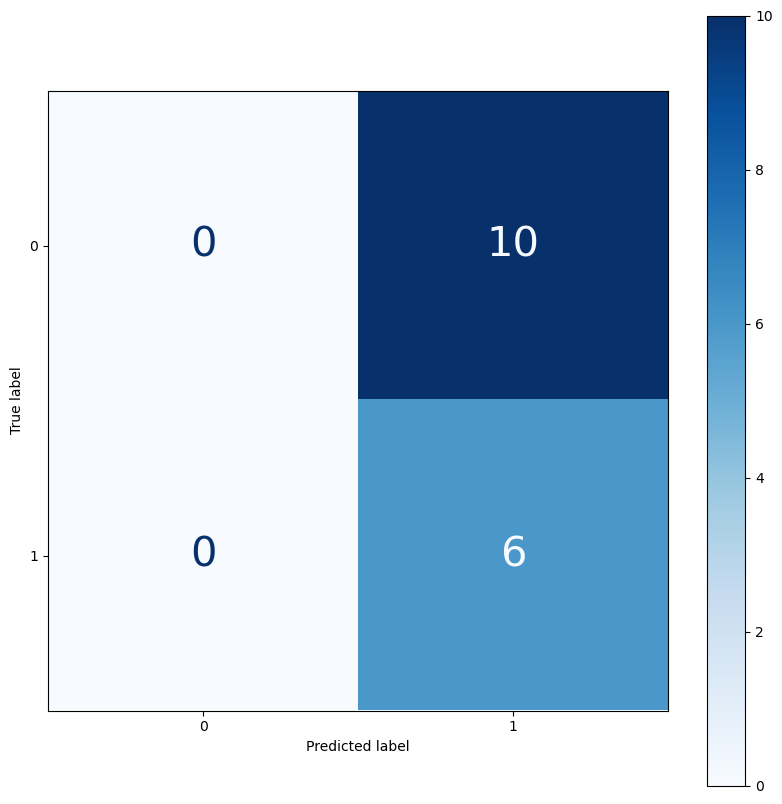

In [24]:
cm = confusion_matrix(testY, np.argmax(predY, axis = -1)) # confusion matrix
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

## Save Model

In [25]:
CCT = model
CCT.save("ViT_model")
np.save('history_ViT.npy',history.history)

INFO:tensorflow:Assets written to: ViT_model/assets


INFO:tensorflow:Assets written to: ViT_model/assets


## Let's print classification report

<Axes: >

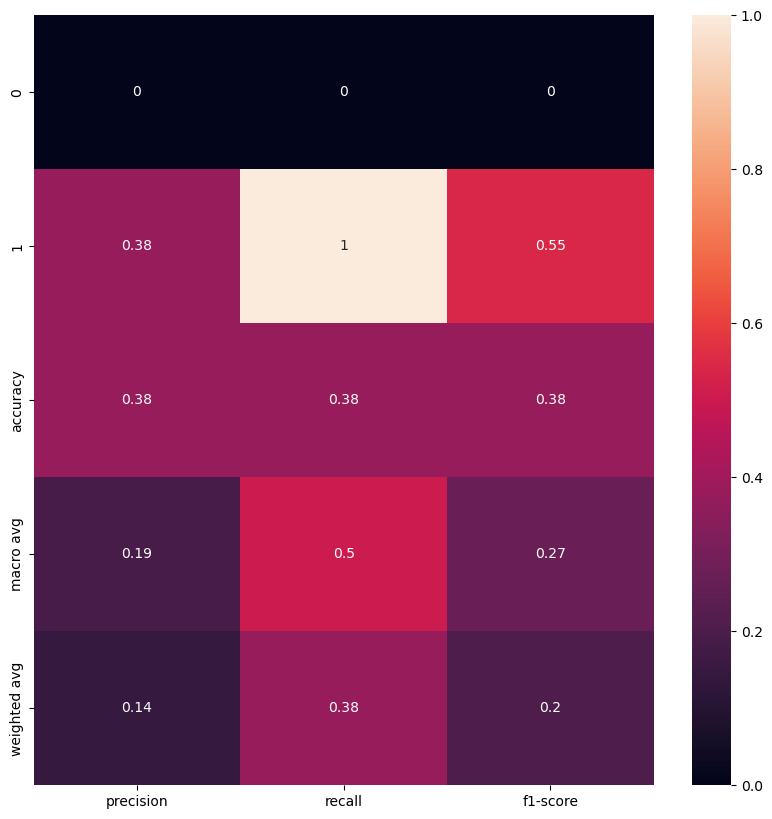

In [26]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, ax=ax)

## Results

In [27]:
y_val = test_gen.classes
y_pred = model.predict(test_gen)
confidence = np.max(y_pred,axis=1)
y_pred = np.argmax(y_pred,axis=1)

16/16 [==============================] - 0s 8ms/step


In [28]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.38      1.00      0.55         6

    accuracy                           0.38        16
   macro avg       0.19      0.50      0.27        16
weighted avg       0.14      0.38      0.20        16



In [29]:
class_indices = test_gen.class_indices
indices = {v:k for k,v in class_indices.items()}

In [30]:
filenames = test_gen.filenames

We get the confidence values here

In [31]:
result_df = pd.DataFrame()
result_df['filename'] = filenames
result_df['actual'] = y_val
result_df['predicted'] = y_pred
result_df['actual'] = result_df['actual'].apply(lambda x: indices[x])
result_df['predicted'] = result_df['predicted'].apply(lambda x: indices[x])
result_df.loc[result_df['actual']==result_df['predicted'],'Same'] = True
result_df.loc[result_df['actual']!=result_df['predicted'],'Same'] = False
result_df['confidence'] = confidence
result_df.head(10)

filename   actual predicted   Same  confidence
0   missing/frame_128.jpg  missing   present  False    0.576644
1  missing/frame_2133.jpg  missing   present  False    0.584038
2  missing/frame_2243.jpg  missing   present  False    0.565589
3  missing/frame_2299.jpg  missing   present  False    0.575561
4  missing/frame_2328.jpg  missing   present  False    0.571290
5  missing/frame_2460.jpg  missing   present  False    0.544094
6  missing/frame_2578.jpg  missing   present  False    0.564984
7   missing/frame_542.jpg  missing   present  False    0.567942
8   missing/frame_605.jpg  missing   present  False    0.570931
9   missing/frame_930.jpg  missing   present  False    0.573597

In [32]:
# result_df = result_df.sample(frac=1).reset_index(drop=True)

In [33]:
# from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
# def readImage(path):
#     img = load_img(path,color_mode='rgb',target_size=(image_size,image_size))
#     img = img_to_array(img)
#     img = img/255.
    
#     return img

# def display_images(temp_df):
#     temp_df = temp_df.reset_index(drop=True)
#     plt.figure(figsize = (20 , 20))
#     n = 0
#     for i in range(15):
#         n+=1
#         plt.subplot(5 , 5, n)
#         plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
#         image = readImage(f"{dataset_path}/test/{temp_df.filename[i]}")
#         plt.imshow(image)
#         plt.title("Actual Class:" + str(temp_df.actual[i]) + "\n" + "Predicted Class:" + str(temp_df.predicted[i]) + "\n" + "Confidence:" + str(temp_df.confidence[i]))

Correctly classified Inputs

In [34]:
# display_images(result_df[result_df['Same']==True])

Misclassified Inputs

In [35]:
# display_images(result_df[result_df['Same']!=True])

# Compact Convoutional Transformer (CCT)

In [36]:
from tensorflow.keras import layers
from tensorflow import keras
class ConvolutionalTokenizer(layers.Layer):
    """
    Creates Convolutional Tokens of images for feeding to Transformer Encoder.
    """
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,conv_layers=2,num_output_channels=[64, 128],**kwargs,):
        super(ConvolutionalTokenizer, self).__init__(**kwargs)
        
        # Creating a Sequential Keras Model for Tokenizing images
        self.conv_model = keras.Sequential()
        # Created the required number of convolutional layer
        for i in range(conv_layers):
            # Adding a conv2d layer with ReLU activation as suggested by authors
            self.conv_model.add(layers.Conv2D(num_output_channels[i],kernel_size,stride,padding="valid",use_bias=False,activation="relu",kernel_initializer="he_normal"))
            # Zero Padding
            self.conv_model.add(layers.ZeroPadding2D(padding))
            # Pooling over the image with 3x3 kernel having padding='same' and stride=2   
            self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))

    def call(self, images):
        # Reshaping the outputs by flattening them
        outputs = self.conv_model(images)
        Flattened = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[3]),
        )
        return Flattened

    # Adding Learnable Positional Embeddings
    def pos_embeddings(self, image_size):
        inp = tf.ones((1, image_size, image_size, 1))
        out = self.call(inp)
        seq_len = tf.shape(out)[1]
        projection_dim = tf.shape(out)[-1]

        embed_layer = layers.Embedding(
            input_dim=seq_len, output_dim=projection_dim
        )
        return embed_layer, seq_len

In [37]:
def mlp(x, hidden_units, dropout):
    """
    Creates A Feed Forward Network`
    
    Args:
        hidden_units: Number of hidden units in MLP
        dropout: The Rate of dropout which is to be applied.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout)(x)
    return x

In [38]:
def Transformer_Encoder(L,embedded_patches,num_heads,projection_dim,transformer_units):
    """
    Transformer Encoder Block
    
    Args: 
        L: number of transformer_layers
        
        embedded_patches: Patches from the Convolutional Tokenizer block
        
        num_heads: Number of Attention Heads
        
        projection_dim: Size of each attention head for query and key
        
        transformer_units: hidden units of MLP
    """
    
    
    # Iterating over the number of transformer layers
    for i in range(L):
        # Normalizing the input patches
        norm = layers.LayerNormalization(epsilon=1e-5)(embedded_patches)
        # Feeding to MHA
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(norm,norm)
        # Shortcut skip connection
        skip1 = layers.Add()([attention_output, embedded_patches])
        # Normalizing 
        norm2= layers.LayerNormalization(epsilon=1e-5)(skip1)
        
        # Feed Forward MLP
        ffn = mlp(norm2, hidden_units=transformer_units, dropout=0.1)

        # Shortcut skip connection
        embedded_patches = layers.Add()([ffn, skip1])
        
        return embedded_patches

In [39]:
def SeqPool(trans_enco_out):
    """
    Sequence Pooling block.
    
    Args: 
        trans_enco_out: Takes in the Output of transformer encoder block 
    
    Returns:
        A 1xD output to be fed to final classifier
    """
    # Normalizing the output of transformer enocder layer
    normalized = layers.LayerNormalization(epsilon=1e-5)(trans_enco_out)
    # Adding a linear layer
    linear=layers.Dense(1)(normalized)
    # Applying Softmax to the linear layer
    soft = tf.nn.softmax(linear, axis=1)
    # Multiplying the softmax of linear layer with the normalized output of orignal output of the transformer encoder block
    mult = tf.matmul(soft, normalized, transpose_a=True)
    # Squeezing the dimensions
    seq_pool_output = tf.squeeze(mult, -2)

    return seq_pool_output

In [40]:
def CompactConvolutionalTransformer(image_size=image_size,num_classes=n_classes,input_shape=(image_size, image_size, 1),projection_dim=128,num_heads=2,L=2,transformer_units=[128,128]):
    """
    CCT model
    
    Args:
        image_size: size of image
        
        num_classes: Number of classes of output
        
        input_shape: shape of image
        
        projection_dim: Size of each attention head for query and key
        
        num_heads: Number of heads of MHA
        
        L: Number of transformer encoder layers
    
    Returns:
        CCT Model
    """
    
    inputs = layers.Input(input_shape)
    """
    Convolutional Tokenization Block as shown in above image
    """
    # Encode patches.
    conv_tokenizer = ConvolutionalTokenizer()
    embedded_patches = conv_tokenizer(inputs)

    # Adding positional embedding.
    pos_embed, seq_length = conv_tokenizer.pos_embeddings(image_size)
    positions = tf.range(start=0, limit=seq_length, delta=1)
    position_embeddings = pos_embed(positions)
    embedded_patches += position_embeddings
    
    
    """
    Transformer with Sequence Pooling Block as shown in above image
    """
    
    # Feeding embedded patches after adding embeddings to transformer encoder block
    embedded_patches=Transformer_Encoder(L,embedded_patches,num_heads=num_heads,projection_dim=projection_dim,transformer_units=transformer_units)
    
    # Applying sequence pooling to output of the transformer encoder block
    sequence_pooling=SeqPool(embedded_patches)
    
    # Adding a dense layer for predictions
    output= layers.Dense(num_classes,activation='softmax')(sequence_pooling)
    
    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [41]:
print(CompactConvolutionalTransformer().summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 convolutional_tokenizer (C  (None, 3136, 128)            74304     ['input_1[0][0]']             
 onvolutionalTokenizer)                                                                           
                                                                                                  
 tf.__operators__.add (TFOp  (None, 3136, 128)            0         ['convolutional_tokenizer[0][0
 Lambda)                                                            ]']                           
                                                                                              

## **Training the Model**

In [42]:
valid_gen.n

28

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

CCT = CompactConvolutionalTransformer()
    
CCT.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                         tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                        ],
             )


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 0,
                                                 patience = 15,
                                                 mode = 'auto',
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './CCTmodel.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

callbacks = [earlystopping, lr_scheduler, checkpointer]

startTrain_CCT = time()
history = CCT.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)
time_passed_CCT = time()-startTrain_CCT

Epoch 1/200
8/8 [==============================] - ETA: 0s - loss: 1.4009 - accuracy: 0.5393 - top-5-accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to ./CCTmodel.hdf5
8/8 [==============================] - 6s 420ms/step - loss: 1.4009 - accuracy: 0.5393 - top-5-accuracy: 1.0000 - val_loss: 0.7748 - val_accuracy: 0.4583 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.8928 - accuracy: 0.4157 - top-5-accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.45833 to 0.58333, saving model to ./CCTmodel.hdf5
8/8 [==============================] - 3s 340ms/step - loss: 0.8928 - accuracy: 0.4157 - top-5-accuracy: 1.0000 - val_loss: 0.8066 - val_accuracy: 0.5833 - val_top-5-accuracy: 1.0000 - lr: 9.6194e-04
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.7167 - accuracy: 0.5843 - top-5-accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.58333
8/8 [=====================

## Running time & memory occupation(complexity) of the model

In [44]:
print("Trainable parameters: ",CCT.count_params() )

print("Running time: ",t.strftime("%Hh%Mm%Ss", t.gmtime(time_passed_CCT)))

Trainable parameters:  240451
Running time:  00h01m15s


## Let's PREDICT!!

In [45]:
test_gen.reset()
predY=CCT.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

16/16 [==============================] - 0s 8ms/step


## Confusion Matrix

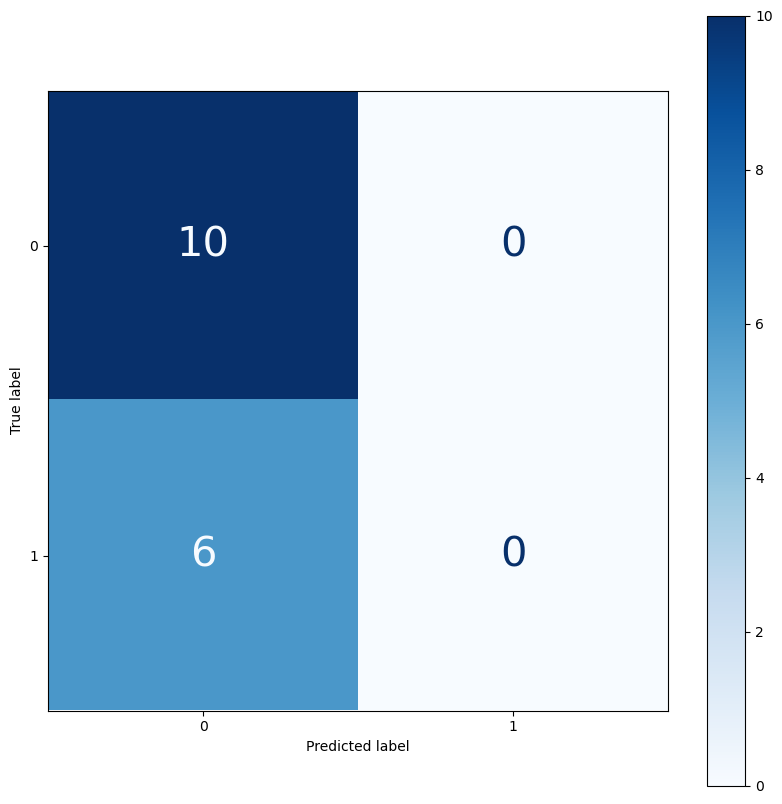

In [46]:
cm = confusion_matrix(testY, np.argmax(predY, axis = -1)) # confusion matrix
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

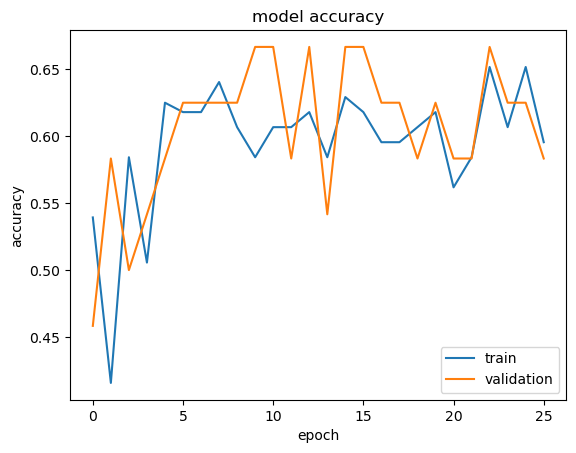

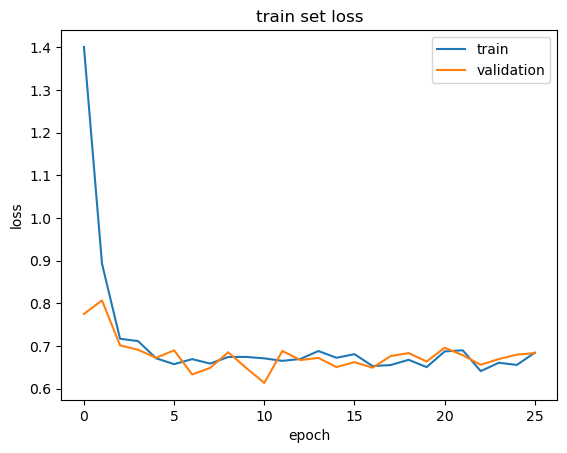

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Save Model

In [48]:
CCT.save("CCT_model")
np.save('history_CCT.npy',history.history)

INFO:tensorflow:Assets written to: CCT_model/assets


INFO:tensorflow:Assets written to: CCT_model/assets


## Let's print classification report

<Axes: >

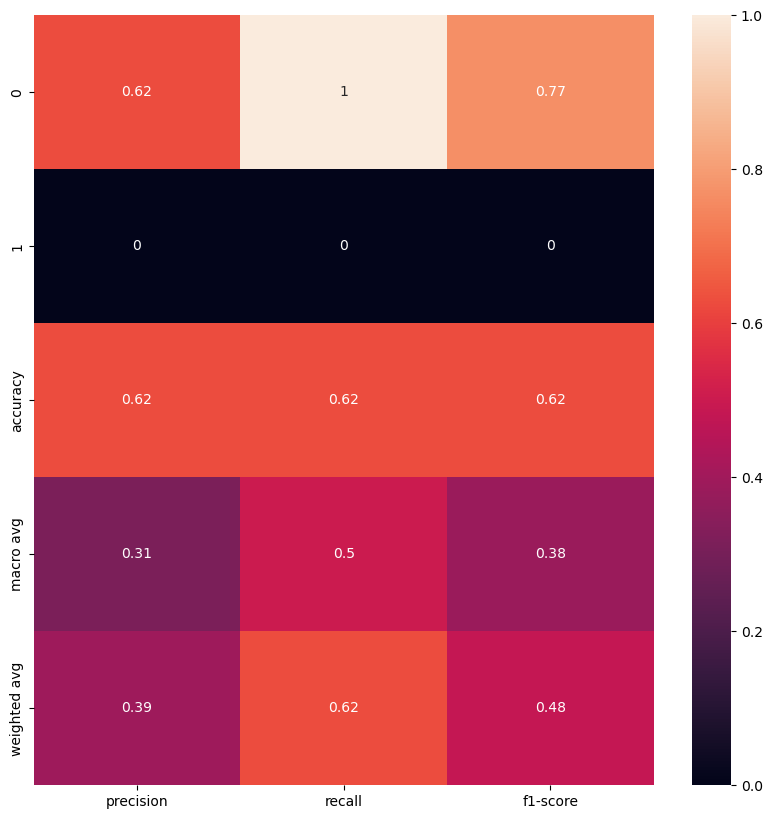

In [49]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, ax=ax)

## Results

In [50]:
y_val = test_gen.classes
y_pred = model.predict(test_gen)
confidence = np.max(y_pred,axis=1)
y_pred = np.argmax(y_pred,axis=1)

16/16 [==============================] - 0s 8ms/step


In [51]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.38      1.00      0.55         6

    accuracy                           0.38        16
   macro avg       0.19      0.50      0.27        16
weighted avg       0.14      0.38      0.20        16



# SEQ MODEL

In [52]:
# Define the input layer
input_layer = tf.keras.layers.Input(shape=(image_size, image_size, 1))

# Define the first convolutional layer
conv_layer_1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
conv_layer_1 = tf.keras.layers.BatchNormalization()(conv_layer_1)

# Define the second convolutional layer
conv_layer_2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(conv_layer_1)
conv_layer_2 = tf.keras.layers.BatchNormalization()(conv_layer_2)

# Define the first max pooling layer
pool_layer_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_layer_2)

# Define the third convolutional layer
conv_layer_3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(pool_layer_1)
conv_layer_3 = tf.keras.layers.BatchNormalization()(conv_layer_3)

# Define the fourth convolutional layer
conv_layer_4 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv_layer_3)
conv_layer_4 = tf.keras.layers.BatchNormalization()(conv_layer_4)

# Define the second max pooling layer
pool_layer_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_layer_4)

# Define the fifth convolutional layer
conv_layer_5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(pool_layer_2)
conv_layer_5 = tf.keras.layers.BatchNormalization()(conv_layer_5)

# Define the sixth convolutional layer
conv_layer_6 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(conv_layer_5)
conv_layer_6 = tf.keras.layers.BatchNormalization()(conv_layer_6)

# Define the third max pooling layer
pool_layer_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_layer_6)

# Define the flatten layer
flatten_layer = tf.keras.layers.Flatten()(pool_layer_3)

# Define the first fully connected layer
fc_layer_1 = tf.keras.layers.Dense(512, activation='relu')(flatten_layer)
fc_layer_1 = tf.keras.layers.BatchNormalization()(fc_layer_1)

#Define the second fully connected layer
fc_layer_2 = tf.keras.layers.Dense(256, activation='relu')(fc_layer_1)
fc_layer_2 = tf.keras.layers.BatchNormalization()(fc_layer_2)

#Define the output layer
output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(fc_layer_2)

#Create the model
CNN_seq = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    
CNN_seq.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                         tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                        ],
             )


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 0,
                                                 patience = 15,
                                                 mode = 'auto',
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './CNN_seq.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

callbacks = [earlystopping, lr_scheduler, checkpointer]

startTrain_seq = time()
history = CNN_seq.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)
time_passed_CCN_seq = time()-startTrain_seq

Epoch 1/200
8/8 [==============================] - ETA: 0s - loss: 1.3636 - accuracy: 0.5730 - top-5-accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to ./CNN_seq.hdf5
8/8 [==============================] - 6s 369ms/step - loss: 1.3636 - accuracy: 0.5730 - top-5-accuracy: 1.0000 - val_loss: 0.6687 - val_accuracy: 0.6250 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.6067 - top-5-accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.62500
8/8 [==============================] - 2s 224ms/step - loss: 0.7576 - accuracy: 0.6067 - top-5-accuracy: 1.0000 - val_loss: 1.8498 - val_accuracy: 0.4583 - val_top-5-accuracy: 1.0000 - lr: 9.6194e-04
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.6854 - top-5-accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.62500
8/8 [==============================] - 2s 228ms/step - loss: 0.7

In [54]:
print("Trainable parameters: ",CNN_seq.count_params() )

print("Running time: ",t.strftime("%Hh%Mm%Ss", t.gmtime(time_passed_CCN_seq)))

Trainable parameters:  51803874
Running time:  00h00m34s


In [55]:
test_gen.reset()
predY=CNN_seq.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

16/16 [==============================] - 0s 5ms/step


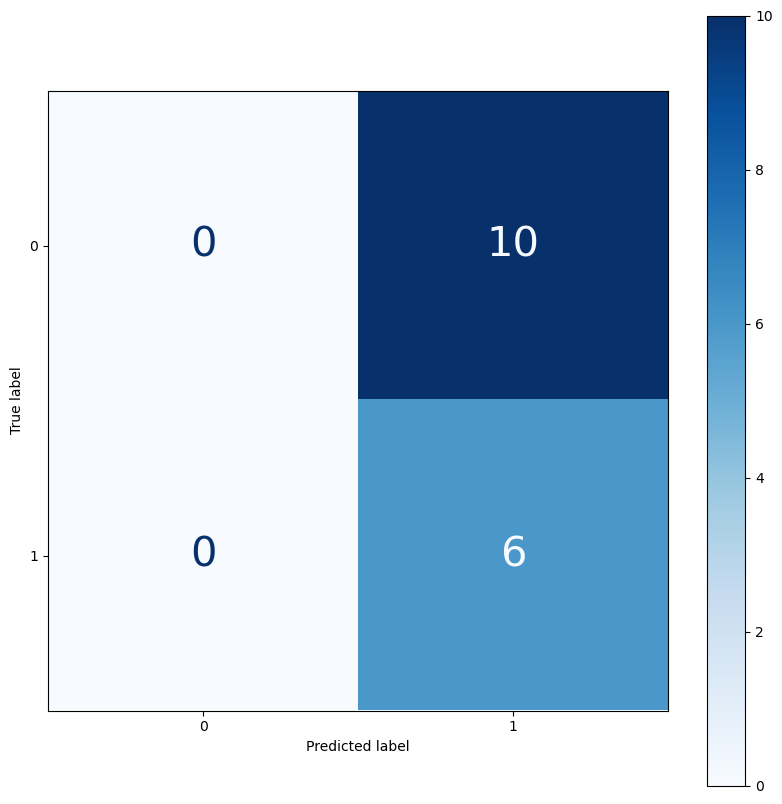

In [56]:
cm = confusion_matrix(testY, np.argmax(predY, axis = -1)) # confusion matrix
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

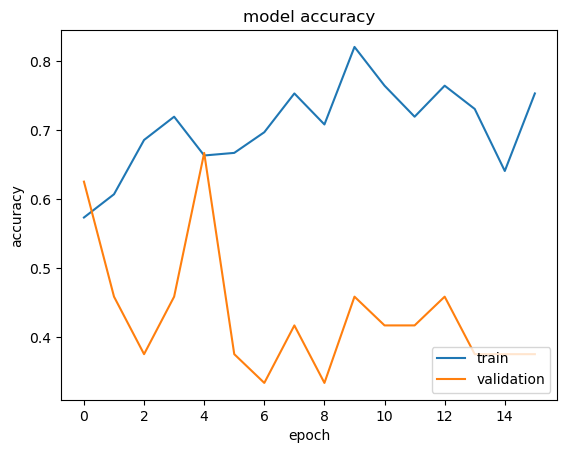

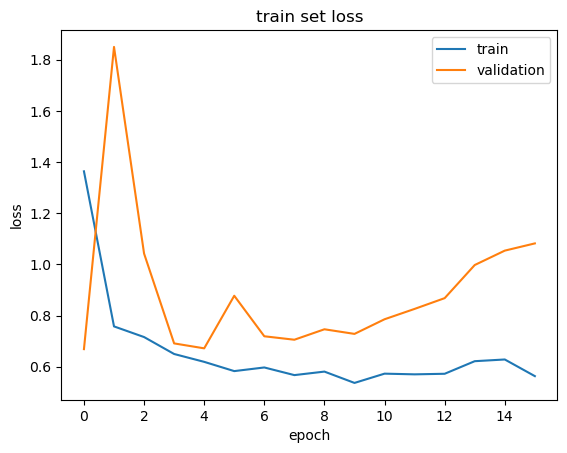

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [58]:
CNN_seq.save("CNN_seq")
np.save('history_CNN_seq.npy',history.history)

INFO:tensorflow:Assets written to: CNN_seq/assets


INFO:tensorflow:Assets written to: CNN_seq/assets


## Let's print classification report

<Axes: >

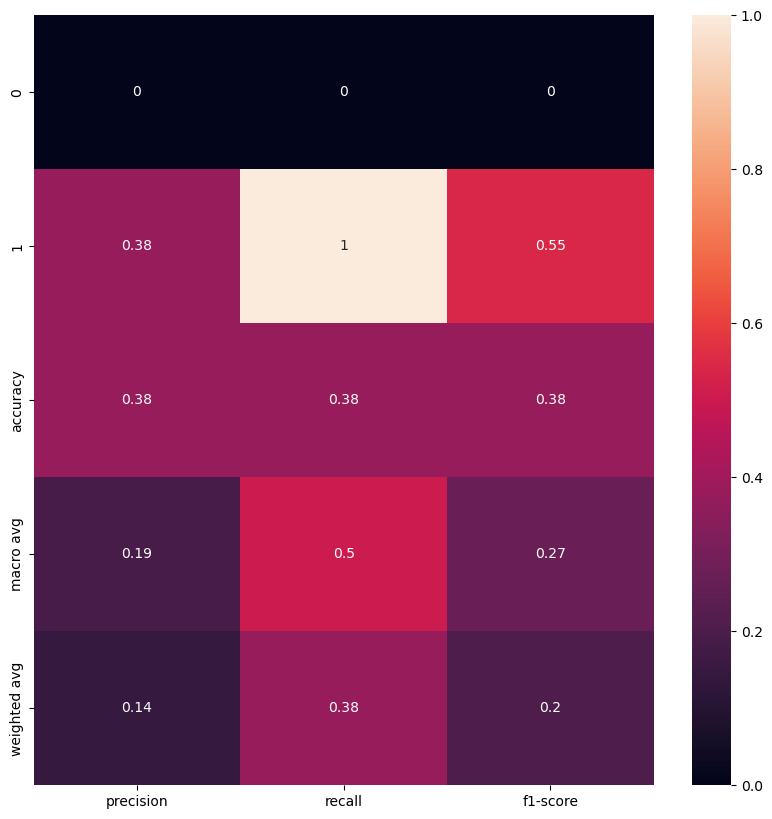

In [59]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, ax=ax)

## Results

In [60]:
y_val = test_gen.classes
y_pred = model.predict(test_gen)
confidence = np.max(y_pred,axis=1)
y_pred = np.argmax(y_pred,axis=1)

16/16 [==============================] - 0s 9ms/step


In [61]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.38      1.00      0.55         6

    accuracy                           0.38        16
   macro avg       0.19      0.50      0.27        16
weighted avg       0.14      0.38      0.20        16



# Attention CNN

In [11]:
# Define the input layer
input_layer = tf.keras.layers.Input(shape=(image_size, image_size, 1))

# Define the first parallel connection
parallel_1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
parallel_1 = tf.keras.layers.BatchNormalization()(parallel_1)
parallel_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(parallel_1)

# Define the second parallel connection
parallel_2 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(input_layer)
parallel_2 = tf.keras.layers.BatchNormalization()(parallel_2)
parallel_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(parallel_2)

# Define the third parallel connection
parallel_3 = tf.keras.layers.Conv2D(32, (7, 7), padding='same', activation='relu')(input_layer)
parallel_3 = tf.keras.layers.BatchNormalization()(parallel_3)
parallel_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(parallel_3)

# Concatenate the outputs of the parallel connections
concatenated = tf.keras.layers.concatenate([parallel_1, parallel_2, parallel_3])

# Define the attention mechanism
attention_weights = tf.keras.layers.Dense(1, activation='softmax')(concatenated)
attention_output = tf.keras.layers.multiply([concatenated, attention_weights])

# Define the flatten layer
flatten_layer = tf.keras.layers.Flatten()(attention_output)

# Define the first fully connected layer
fc_layer_1 = tf.keras.layers.Dense(512, activation='relu')(flatten_layer)
fc_layer_1 = tf.keras.layers.BatchNormalization()(fc_layer_1)

# Define the second fully connected layer
fc_layer_2 = tf.keras.layers.Dense(256, activation='relu')(fc_layer_1)
fc_layer_2 = tf.keras.layers.BatchNormalization()(fc_layer_2)

# Define the output layer
output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(fc_layer_2)

# Create the model
CNN_attention = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

2023-12-05 00:49:56.448893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 00:49:56.470962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 00:49:56.471207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    
CNN_attention.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                         tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                        ],
             )


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 0,
                                                 patience = 15,
                                                 mode = 'auto',
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model_att.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

callbacks = [earlystopping, lr_scheduler, checkpointer]

startTrain_att = time()
history = CNN_attention.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)
time_passed_model_att = time()-startTrain_att

Epoch 1/200


2023-12-05 00:50:05.062630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-12-05 00:50:05.636521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-05 00:50:05.640650: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9518043cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 00:50:05.640679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-12-05 00:50:05.644688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 00:50:05.736992: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

8/8 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.5938 - top-5-accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to ./model_att.hdf5


2023-12-05 00:50:09.428379: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.


8/8 [==============================] - 8s 447ms/step - loss: 0.9725 - accuracy: 0.5938 - top-5-accuracy: 1.0000 - val_loss: 0.6468 - val_accuracy: 0.5833 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.6979 - top-5-accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.58333
8/8 [==============================] - 2s 226ms/step - loss: 0.6539 - accuracy: 0.6979 - top-5-accuracy: 1.0000 - val_loss: 0.7082 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000 - lr: 9.6194e-04
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.7978 - top-5-accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.58333
8/8 [==============================] - 2s 212ms/step - loss: 0.5617 - accuracy: 0.7978 - top-5-accuracy: 1.0000 - val_loss: 0.7111 - val_accuracy: 0.4583 - val_top-5-accuracy: 1.0000 - lr: 8.5355e-04
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss:

In [13]:
print("Trainable parameters: ",CNN_attention.count_params() )

print("Running time: ",t.strftime("%Hh%Mm%Ss", t.gmtime(time_passed_model_att)))

Trainable parameters:  154279331
Running time:  00h00m32s


In [14]:
test_gen.reset()
predY=CNN_attention.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

16/16 [==============================] - 0s 5ms/step


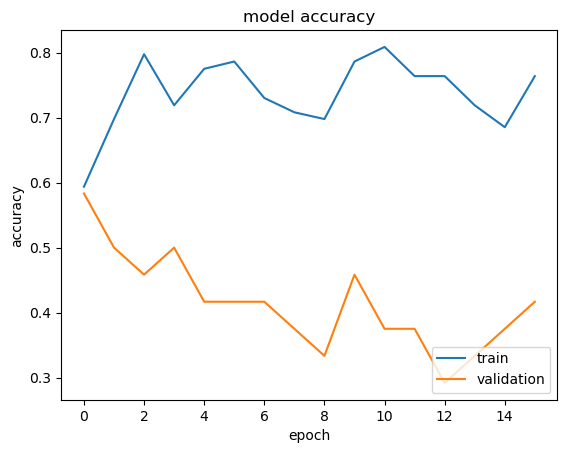

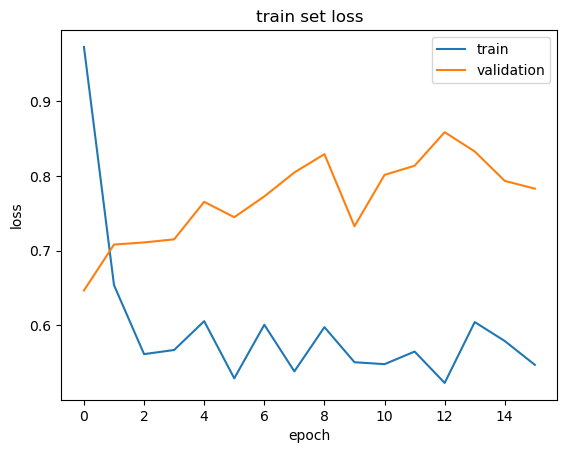

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
CNN_attention.save("CNN_attention")
np.save('history_CNN_attention.npy',history.history)

2023-12-05 00:51:28.547607: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2023-12-05 00:51:28.848786: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2023-12-05 00:51:29.124951: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: CNN_attention/assets


INFO:tensorflow:Assets written to: CNN_attention/assets


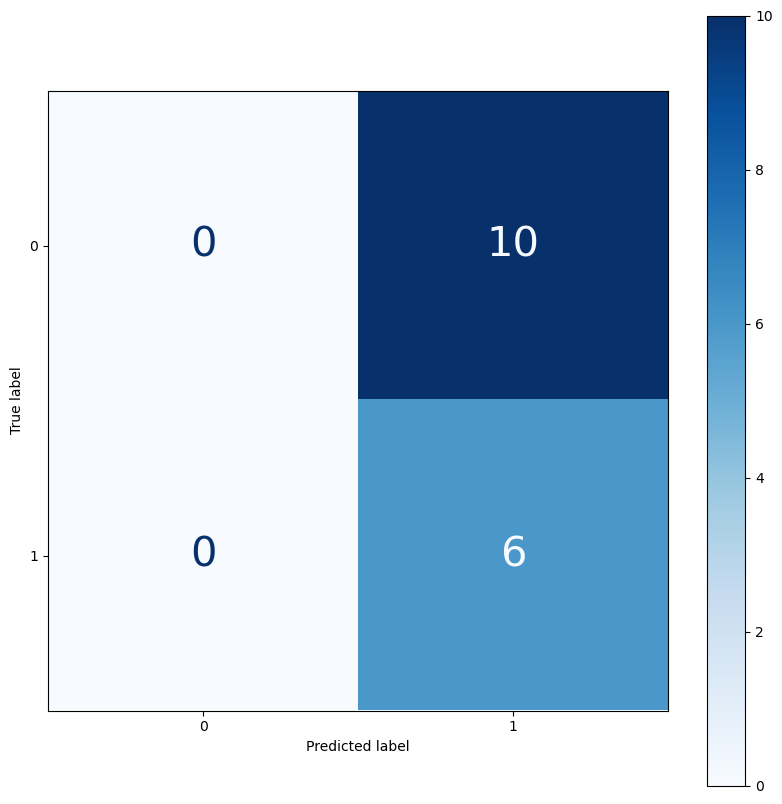

In [17]:
cm = confusion_matrix(testY, np.argmax(predY, axis = -1)) # confusion matrix
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

## Let's print classification report

<Axes: >

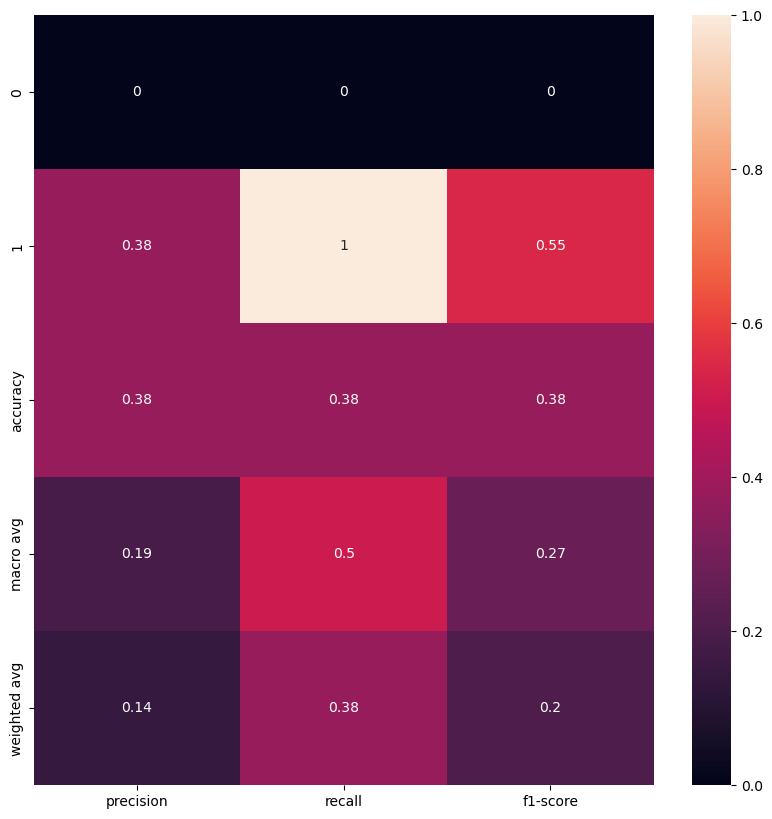

In [18]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, ax=ax)

## Results

In [20]:
y_val = test_gen.classes
y_pred = CNN_attention.predict(test_gen)
confidence = np.max(y_pred,axis=1)
y_pred = np.argmax(y_pred,axis=1)

16/16 [==============================] - 0s 5ms/step


In [21]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.38      1.00      0.55         6

    accuracy                           0.38        16
   macro avg       0.19      0.50      0.27        16
weighted avg       0.14      0.38      0.20        16



In [12]:
CNN_Sequential = tf.keras.models.load_model('./CNN_seq')
CNN_Attention = tf.keras.models.load_model('./CNN_attention')
ViT = tf.keras.models.load_model('./ViT_model')
CCT = tf.keras.models.load_model('./CCT_model')

2023-12-05 00:56:42.826993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 00:56:42.856706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 00:56:42.856977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Ensemble Model

In [13]:
from sklearn.ensemble import VotingClassifier
# Ensemble of Models 
estimator = [] 
estimator.append(('ViT',ViT))
estimator.append(('CTT', CCT)) 
estimator.append(('CNN_Sequential', CNN_Sequential))
estimator.append(('CNN_Attention', CNN_Attention)) 

In [14]:
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

In [15]:
test_gen.reset()
pred_ViT=ViT.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

2023-12-05 00:57:10.266280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-05 00:57:10.274646: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Graph execution error:

Detected at node 'add' defined at (most recent call last):
Node: 'add'
required broadcastable shapes
	 [[{{node add}}]] [Op:__inference_predict_function_29334]

In [16]:
test_gen.reset()
pred_CCT=CCT.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)

2023-12-05 00:57:44.500014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-12-05 00:57:44.999353: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/tf.__operators__.add_1/AddV2' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/traitlets/config/application.py", line 1046, in launch_instance
      app.start()
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_82821/263923385.py", line 2, in <module>
      pred_CCT=CCT.predict_generator(
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/training.py", line 2885, in predict_generator
      return self.predict(
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/layers/core/tf_op_layer.py", line 242, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "/opt/anaconda3/envs/pytorch_cuda_11.8/lib/python3.11/site-packages/keras/src/layers/core/tf_op_layer.py", line 279, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'model_1/tf.__operators__.add_1/AddV2'
required broadcastable shapes
	 [[{{node model_1/tf.__operators__.add_1/AddV2}}]] [Op:__inference_predict_function_29622]

In [ ]:
test_gen.reset()
pred_CNN_Sequential=CNN_Sequential.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)

In [ ]:
test_gen.reset()
pred_CNN_Attention=CNN_Attention.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)

In [ ]:
stack=np.dstack((pred_ViT,pred_CCT,pred_CNN_Sequential,pred_CNN_Attention))
avg_ensemble_prob=np.mean(stack,axis=-1)
avg_ensemble_pred=np.argmax(avg_ensemble_prob,axis=-1)

In [ ]:
cm = confusion_matrix(testY, avg_ensemble_pred) # confusion matrix
cr=(classification_report(testY, avg_ensemble_pred, target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.savefig('ensemble_conf.png', dpi=1200)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, ax=ax)

In [ ]:
cr1=(classification_report(testY, avg_ensemble_pred, target_names=class_to_label_map, output_dict=True, digits=4)) #other scores
cr2=(classification_report(testY, np.argmax(pred_ViT, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores
cr3=(classification_report(testY, np.argmax(pred_CCT, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores
cr4=(classification_report(testY, np.argmax(pred_CNN_Sequential, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores
cr6=(classification_report(testY, np.argmax(pred_CNN_Attention, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

print("ViT Accuracy:" + str(cr2['accuracy']))
print("CCT Accuracy:" + str(cr3['accuracy']))
print("CNN_Sequential Accuracy:" + str(cr4['accuracy']))
print("CNN_Attention Accuracy:" + str(cr6['accuracy']))
print("Ensemble Accuracy:" + str(cr1['accuracy']))

In [ ]:
y_val = test_gen.classes
y_pred = CNN_Attention.predict(test_gen)
confidence = np.max(y_pred,axis=1)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_val,y_pred))

In [ ]:
class_indices = test_gen.class_indices
indices = {v:k for k,v in class_indices.items()}

In [ ]:
filenames = test_gen.filenames

In [ ]:
result_df = pd.DataFrame()
result_df['filename'] = filenames
result_df['actual'] = y_val
result_df['predicted'] = y_pred
result_df['actual'] = result_df['actual'].apply(lambda x: indices[x])
result_df['predicted'] = result_df['predicted'].apply(lambda x: indices[x])
result_df.loc[result_df['actual']==result_df['predicted'],'Same'] = True
result_df.loc[result_df['actual']!=result_df['predicted'],'Same'] = False
result_df['confidence'] = confidence
result_df.head(10)

In [ ]:
result_df = result_df.sample(frac=1).reset_index(drop=True)

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
def readImage(path):
    img = load_img(path,color_mode='grayscale',target_size=(image_size,image_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    numbers_of_item = temp_df.shape[0]
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    if(numbers_of_item >= 15): 
        for i in range(15):
            n+=1
            plt.subplot(5 , 5, n)
            plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
            image = readImage(f"{dataset_path}\\test\\{temp_df.filename[i]}")
            plt.imshow(image)
            plt.title("Actual Class:" + str(temp_df.actual[i]) + "\n" + "Predicted Class:" + str(temp_df.predicted[i]) + "\n" + "Confidence:" + str(temp_df.confidence[i]))
    else:
        for i in range(numbers_of_item):
            n+=1
            plt.subplot(3 , 3, n)
            plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
            image = readImage(f"{dataset_path}\\test\\{temp_df.filename[i]}")
            plt.imshow(image)
            plt.title("Actual Class:" + str(temp_df.actual[i]) + "\n" + "Predicted Class:" + str(temp_df.predicted[i]) + "\n" + "Confidence:" + str(temp_df.confidence[i]))

In [ ]:
display_images(result_df[result_df['Same']==True])
plt.tight_layout()
plt.savefig('confidence', dpi=1200)

In [ ]:
display_images(result_df[result_df['Same']!=True])

In [ ]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=[model.layers[-9].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [ ]:
import matplotlib.cm as cm
from tensorflow.keras.models import Model
result_df

In [ ]:
def gradCAMImage(image):
    path = f"dataset\\test\\{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,CNN_Sequential)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [ ]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = result_df[result_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(125):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [ ]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
# misclassified, m_titles = gradcam_of_images(correct_class=False)

In [ ]:
def display_heatmaps(classified_images,titles,name):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(25):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    #plt.tight_layout()
    #plt.savefig(name, dpi=1200)
    plt.show()

    plt.figure(figsize = (20 , 20))
    for i in range(25, 50):
        n+=1
        plt.subplot(5 , 5, n-25)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    #plt.tight_layout()
    #plt.savefig(name, dpi=1200)
    plt.show()

    plt.figure(figsize = (20 , 20))
    for i in range(50, 75):
        n+=1
        plt.subplot(5 , 5, n-50)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    #plt.tight_layout()
    #plt.savefig(name, dpi=1200)
    plt.show()

    plt.figure(figsize = (20 , 20))
    for i in range(75, 125):
        n+=1
        plt.subplot(5 , 5, n-75)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    #plt.tight_layout()
    #plt.savefig(name, dpi=1200)
    plt.show()

In [ ]:
len(correctly_classified)

In [ ]:
display_heatmaps(correctly_classified,c_titles,'correctly_classified')

In [ ]:
display_heatmaps(misclassified,m_titles,'misclassified')

In [2]:
history_ViT=np.load('history_ViT.npy',allow_pickle='TRUE').item()
history_CCT=np.load('history_CCT.npy',allow_pickle='TRUE').item()
history_Seq=np.load('history_CNN_attention.npy',allow_pickle='TRUE').item()
history_Att=np.load('history_CNN_seq.npy',allow_pickle='TRUE').item()

In [8]:
history_Seq['val_accuracy']

[0.5833333134651184,
 0.5,
 0.4583333432674408,
 0.5,
 0.4166666567325592,
 0.4166666567325592,
 0.4166666567325592,
 0.375,
 0.3333333432674408,
 0.4583333432674408,
 0.375,
 0.375,
 0.2916666567325592,
 0.3333333432674408,
 0.375,
 0.4166666567325592]

In [ ]:
plt.plot(history_ViT['val_accuracy'])
plt.plot(history_CCT['val_accuracy'])
plt.plot(history_Seq['val_accuracy'])
plt.plot(history_Att['val_accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['ViT', 'CCT','Sequential CNN', 'Attention-based CNN'], loc='lower right')
plt.tight_layout()
plt.savefig('validation_accuracy.png', dpi=1200)
plt.show()

In [ ]:
plt.plot(history_ViT['loss'])
plt.plot(history_CCT['loss'])
plt.plot(history_Seq['loss'])
plt.plot(history_Att['loss'])
plt.ylabel('Train Set Loss')
plt.xlabel('Epoch')
plt.legend(['ViT', 'CCT','Sequential CNN', 'Attention-based CNN'], loc='upper right')
plt.tight_layout()
plt.savefig('train_loss.png', dpi=1200)
plt.show()

In [ ]:
plt.plot(history_ViT['val_loss'])
plt.plot(history_CCT['val_loss'])
plt.plot(history_Seq['val_loss'])
plt.plot(history_Att['val_loss'])
plt.ylabel('Validation Set Loss')
plt.xlabel('Epoch')
plt.legend(['ViT', 'CCT','Sequential CNN', 'Attention-based CNN'], loc='upper right')
plt.tight_layout()
plt.savefig('val_loss.png', dpi=1200)
plt.show()

In [ ]:
plt.plot(history_ViT['val_accuracy'])
plt.plot(history_CCT['val_accuracy'])
# plt.plot(history_Seq['val_accuracy'])
plt.plot(history_Att['val_accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['ViT', 'CCT','Pallet-Net'], loc='lower right')
plt.tight_layout()
plt.savefig('validation_accuracy.png', dpi=1200)
plt.show()

In [ ]:
plt.plot(history_ViT['accuracy'])
plt.plot(history_CCT['accuracy'])
# plt.plot(history_Seq['val_accuracy'])
plt.plot(history_Att['accuracy'])
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.legend(['ViT', 'CCT','Pallet-Net'], loc='lower right')
plt.tight_layout()
plt.savefig('validation_accuracy.png', dpi=1200)
plt.show()

In [ ]:
plt.plot(history_ViT['loss'])
plt.plot(history_CCT['loss'])
plt.plot(history_Att['loss'])
plt.ylabel('Train Set Loss')
plt.xlabel('Epoch')
plt.legend(['ViT', 'CCT','Pallet-Net'], loc='upper right')
plt.tight_layout()
plt.savefig('train_loss.png', dpi=1200)
plt.show()

In [ ]:
history_Att

In [ ]:
history_CCT


In [ ]:
history_ViT